# **Basic Trends in Open Access Academic Articles**
## Exploring Publication Metrics with *OpenAIRE* 
### A step-by-step walkthrough

This notebook includes the following basic analyses:
- Proportions of articles in open access 
- Proportions of articles by open access status 

See other Notebooks in the repository for other analyses
- Analogous to this notebook with OpenAlex: openalex_oa_analyses.ipynb
- First Analyses: openalex_first_analyses.ipynb
- with OpenAire: openaire_first_analyses.ipynb

### Analysis 1: Assess Proportions of Open Access Articles
> Note: If you want to perform the exact same analysis, then you only have to modify Step 7 to choose the institution you want or adjust/add other parameters.

##### Step 1.1: Imports
To include all necessary imports for setup, you need to install the `requirements.txt` file first. Ensure you're in the right repository and then paste the following command into your terminal: `$ pip install -r requirements.txt`

We need these libraries for:
- `requests`: To make API calls
- `pandas`: To process and manipulate data
- `datetime`: To calculate year ranges
- `matplotlib`: For visualizing data
- `numpy`: To work with arrays

In [1]:
import requests
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from open_colors import colors

##### Step 1.2: Response Validation
This function checks the API response's status code. If it is not 200, it raises an error with details about the failure.

In [2]:
def validate_response(response):
    if response.status_code == 200:
        return response.json()
    else:
        raise Exception(f"Failed to fetch data. Status code for {response.url}: {response.status_code}")

##### Step 1.3: Get OpenOrgs ID from ROR ID

In [ ]:
def get_openorgs_from_ror(ror):
    url = f"https://api.openaire.eu/graph/v1/organizations?pid={ror}"
    response = requests.get(url)
    if response.status_code != 200:
        raise ValueError(f"API error: {response.status_code} - {response.text}")
    data = response.json()
    openorgs = set()
    for record in data.get('results', []):
        openorgs.update([record.get('id', [])])
    return openorgs

##### Step 1.4: Build Parameters 
*Get all aublications within that year range*

In [11]:
def build_url(institution_id, start_year, end_year, base_url):
    params = {
        "relOrganizationId": institution_id,
        "type": "publication",
        "instanceType": "Article",
        "fromPublicationDate": start_year,
        "toPublicationDate": end_year,
        "page": 1,
        "pageSize": 100
    }
    url = f"{base_url}?{requests.compat.urlencode(params)}"
    return url

*Get closed access articles*

In [12]:
def build_non_oa_url(institution_id, start_year, end_year, base_url):
    params = {
        "relOrganizationId": institution_id,
        "type": "publication",
        "instanceType": "Article",
        "bestOpenAccessRightLabel": "CLOSED",
        "fromPublicationDate": start_year,
        "toPublicationDate": end_year,
        "pageSize": 1
    }
    url = f"{base_url}?{requests.compat.urlencode(params)}"
    return url

*Get open access articles*

In [13]:
def build_oa_url(institution_id, start_year, end_year, base_url):
    params = {
        "relOrganizationId": institution_id,
        "type": "publication",
        "instanceType": "Article",
        "bestOpenAccessRightLabel": "OPEN", 
        "fromPublicationDate": start_year,
        "toPublicationDate": end_year,
        "pageSize": 1
    }
    url = f"{base_url}?{requests.compat.urlencode(params)}"
    return url

##### Step 1.5: Fetch Data from OpenAIRE

In [14]:
def fetch_data(url):
    response = requests.get(url)
    print(f"Request URL: {response.url}")
    return validate_response(response)

##### Step 1.6: Process Data

In [15]:
def process_data(data):
    total_publications = data.get("header", {}).get("numFound", 0)
    return total_publications

##### Step 1.7: Define Parameters
Here, we specify:
- `institution_id`: The ID of the institution to analyze.
    - OpenAIRE uses the term "Organization" for institution
    - Search for your institution's ROR from https://explore.openaire.eu/search/advanced/organizations 
    - IDs for institutions begin with "https://ror.org/" followed by letters and numbers.
- `start_year` and `current_year`: The range of publication years to analyze.
    - we use datetime, but you can just type in the years you want

In [20]:
#institution_id = "openorgs____::fb1e14f93f04d43e1a10a9f17d12c669" # Example: OpenOrgs ID of ETH Zürich
institution_id = next(iter(get_openorgs_from_ror("https://ror.org/05a28rw58")), None) # Example: ROR ID of ETH Zürich
base_url = "https://api.openaire.eu/graph/v1/researchProducts"
current_year = datetime.now().year
start_year = current_year - 9
end_year = current_year

##### Step 1.8: Fetch and Process Data for each Category

In [22]:
# Fetch total publications
url = build_url(institution_id, start_year, end_year, base_url=base_url)
data = fetch_data(url)
total_count = process_data(data)

# Fetch closed access publications
non_oa_url = build_non_oa_url(institution_id, start_year, end_year, base_url=base_url)
non_oa_data = fetch_data(non_oa_url)
non_oa_count = process_data(non_oa_data)

# Fetch OA publications
oa_url = build_oa_url(institution_id, start_year, end_year, base_url=base_url)
oa_data = fetch_data(oa_url)
oa_count = process_data(oa_data)

Request URL: https://api.openaire.eu/graph/v1/researchProducts?relOrganizationId=openorgs____%3A%3Afb1e14f93f04d43e1a10a9f17d12c669&type=publication&instanceType=Article&fromPublicationDate=2016&toPublicationDate=2025&page=1&pageSize=100
Request URL: https://api.openaire.eu/graph/v1/researchProducts?relOrganizationId=openorgs____%3A%3Afb1e14f93f04d43e1a10a9f17d12c669&type=publication&instanceType=Article&bestOpenAccessRightLabel=CLOSED&fromPublicationDate=2016&toPublicationDate=2025&pageSize=1
Request URL: https://api.openaire.eu/graph/v1/researchProducts?relOrganizationId=openorgs____%3A%3Afb1e14f93f04d43e1a10a9f17d12c669&type=publication&instanceType=Article&bestOpenAccessRightLabel=OPEN&fromPublicationDate=2016&toPublicationDate=2025&pageSize=1


##### Step 1.9: Compute Ratios and create DataFrame

In [23]:
# Compute ratios
oa_ratio = (oa_count / total_count) * 100
non_oa_ratio = (non_oa_count / total_count) * 100
overall_ratio = 100 - oa_ratio - non_oa_ratio

# Create a DataFrame
df = pd.DataFrame({
    "Total Publications": [total_count],
    "Open Access Publications": [oa_count],
    "Closed Access Publications": [non_oa_count],
    "OA Ratio (%)": [oa_ratio],
    "CA Ratio (%)": [non_oa_ratio],
    "Other (%)": [overall_ratio]
})
    
df

,Total Publications,Open Access Publications,Closed Access Publications,OA Ratio (%),CA Ratio (%),Other (%)
0,117815,91652,15073,77.79315,12.793787,9.413063


>Note: "Other" include the categories *Restricted*, *Open Source*, *Embargo* and else non labeled.

##### Step 1.10: Plot Donut Chart
> Note: Essentially you can choose any kind of visualization you think suits your analysis. Here, we provide possible examples, which you can customize as well:

In [24]:
def plot_oa_donut(oa_count, non_oa_count, overall_ratio):
    labels = ["Open Access", "Closed Access", "Other"]
    sizes = [oa_count, non_oa_count, overall_ratio]
    plot_colors = [colors["teal"][8], colors["red"][7], colors["gray"][5]]

    fig, ax = plt.subplots(figsize=(6, 6))

    wedges, texts, autotexts = ax.pie(
        sizes,
        labels=labels,
        colors=plot_colors,
        autopct='%1.1f%%',
        pctdistance=0.85,
        textprops={"fontsize": 14}
    )

    # Draw center circle to make it a donut
    centre_circle = plt.Circle((0, 0), 0.70, fc='white')
    ax.add_artist(centre_circle)

    # Formatting title
    ax.set_title(
        "Proportions of Open Access vs Closed Access Articles at ETH",
        fontsize=16,
        fontweight='bold'
    )

    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.tight_layout()
    plt.show()

##### Step 1.11: Display Plot

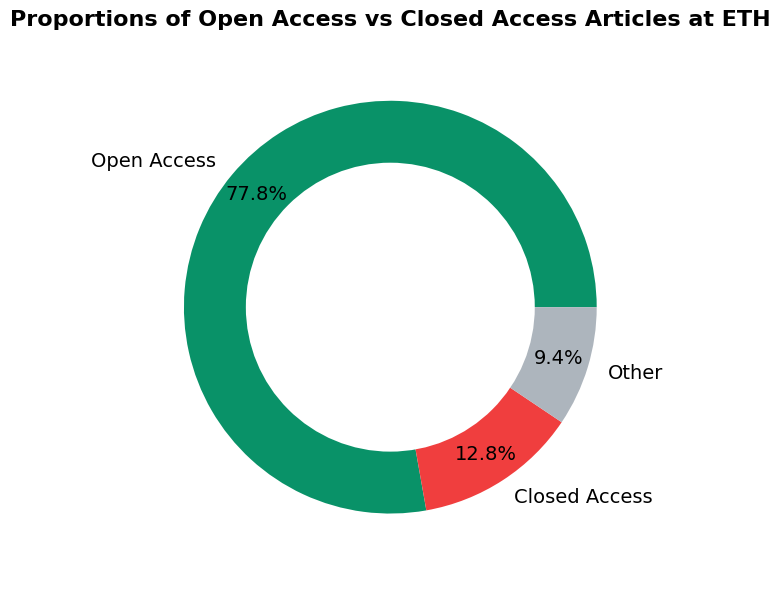

In [25]:
plot_oa_donut(df["OA Ratio (%)"].iloc[0], df["CA Ratio (%)"].iloc[0], df["Other (%)"].iloc[0])

### Analysis 2: Assess Article Proportions by Open Access Status
First, we need to understand how OpenAIRE categorizes the different types of status:

OpenAIRE provides different metadata fields to determine how openly accessible a publication is.

**Key Metadata Fields**
1. `bestOpenAccessRightLabel`
    - Describes the overall access level of a publication.
    - Possible values: OPEN, CLOSED, EMBARGO, RESTRICTED, UNKNOWN, or empty.
2. `isInDiamondJournal`
    - Indicates if a publication is in a Diamond Open Access journal (where both readers and authors do not have to pay).
    - Possible values: True, False, or missing (NaN).
3. `isGreen`
    - Shows if a publication is Green Open Access (a version is available in a repository).
    - Possible values: True, False, or missing (NaN).
4. `openAccessColor`
    - Describes the specific OA type:
        - Gold → Published in a fully open-access journal.
        - Hybrid → Published in a subscription journal, but the author paid for open access.
        - Bronze → Freely available, but without an explicit open license.
        - Missing (NaN) → No classification available.

##### How We Categorize Publications
Each publication can sometimes fit into multiple categories, so we follow these rules to ensure each one appears only once in our analysis:

1. Closed Access (`closed`)
    - Publications where `bestOpenAccessRightLabel` = "CLOSED".
    - These articles are behind a paywall.

2. Other Access (`other`)
    - Publications without a `bestOpenAccessRightLabel` or labeled as something other than "OPEN" or "CLOSED".

3. For publications labeled as "OPEN" (`bestOpenAccessRightLabel` = "OPEN"), we further categorize them:
    - Diamond Open Access (diamond) → If `isInDiamondJournal` = True.
    - Gold Open Access (gold) → If `isInDiamondJournal` = False and `openAccessColor` = "gold".
    - Green Open Access (green) → If `isInDiamondJournal` = False, isGreen = True, and `openAccessColor` ≠ "gold".
    - Bronze Open Access (bronze) → If `isInDiamondJournal` = False, isGreen = False, and `openAccessColor` = "bronze".
    - Hybrid Open Access (hybrid) → If `isInDiamondJournal` = False, isGreen = False, and `openAccessColor` = "hybrid".
    - Other Open Access (other open) → If a publication is labeled as "OPEN" but does not fit into the above categories (e.g., missing `openAccessColor`).

This classification system is inspired by the method described in the article* on Open Access indicators in the CWTS Leiden Ranking 2019 [read more](https://www.cwts.nl/blog?article=n-r2w2a4).

*Van Leeuwen, T. N., Costas, R., & Robinson-Garcia, N. (2019). Indicators of open access publishing in the CWTS Leiden Ranking 2019. CWTS Blog, https://www.cwts.nl/blog?article=n-r2w2a4, accessed 06.03.2025 

##### Step 2.1: Build URLs for a specific status:

*Diamond*

In [26]:
def build_diamond_url(institution_id, start_year, end_year, base_url):
    params = {
        "relOrganizationId": institution_id,
        "type": "publication",
        "instanceType": "Article",
        "bestOpenAccessRightLabel": "OPEN",
        "isInDiamondJournal": True,
        "fromPublicationDate": start_year,
        "toPublicationDate": end_year,
        "pageSize": 1
    }
    url = f"{base_url}?{requests.compat.urlencode(params)}"
    return url

*Gold*

In [27]:
def build_gold_url(institution_id, start_year, end_year, base_url):
    params = {
        "relOrganizationId": institution_id,
        "type": "publication",
        "instanceType": "Article",
        "bestOpenAccessRightLabel": "OPEN",
        "isInDiamondJournal": False,
        "openAccessColor": "gold",
        "fromPublicationDate": start_year,
        "toPublicationDate": end_year,
        "pageSize": 1
    }
    url = f"{base_url}?{requests.compat.urlencode(params)}"
    return url

*Green*

In [28]:
def build_green_total_url(institution_id, start_year, end_year, base_url):
    params = {
        "relOrganizationId": institution_id,
        "type": "publication",
        "instanceType": "Article",
        "bestOpenAccessRightLabel": "OPEN",
        "isInDiamondJournal": False,
        "isGreen": True,
        "fromPublicationDate": start_year,
        "toPublicationDate": end_year,
        "pageSize": 1
    }
    url = f"{base_url}?{requests.compat.urlencode(params)}"
    return url


def build_green_gold_url(institution_id, start_year, end_year, base_url):
    params = {
        "relOrganizationId": institution_id,
        "type": "publication",
        "instanceType": "Article",
        "bestOpenAccessRightLabel": "OPEN",
        "isInDiamondJournal": False,
        "isGreen": True,
        "openAccessColor": "gold",
        "fromPublicationDate": start_year,
        "toPublicationDate": end_year,
        "pageSize": 1
    }
    url = f"{base_url}?{requests.compat.urlencode(params)}"
    return url

*Bronze*

In [29]:
def build_bronze_url(institution_id, start_year, end_year, base_url):
    params = {
        "relOrganizationId": institution_id,
        "type": "publication",
        "instanceType": "Article",
        "bestOpenAccessRightLabel": "OPEN",
        "isInDiamondJournal": False,
        "isGreen": False,
        "openAccessColor": "bronze",
        "fromPublicationDate": start_year,
        "toPublicationDate": end_year,
        "pageSize": 1
    }
    url = f"{base_url}?{requests.compat.urlencode(params)}"
    return url

*Hybrid*

In [30]:
def build_hybrid_url(institution_id, start_year, end_year, base_url):
    params = {
        "relOrganizationId": institution_id,
        "type": "publication",
        "instanceType": "Article",
        "bestOpenAccessRightLabel": "OPEN",
        "isInDiamondJournal": False,
        "isGreen": False,
        "openAccessColor": "hybrid",
        "fromPublicationDate": start_year,
        "toPublicationDate": end_year,
        "pageSize": 1
    }
    url = f"{base_url}?{requests.compat.urlencode(params)}"
    return url

*Other Open*

In [31]:
def build_other_oa_url(institution_id, start_year, end_year, base_url):
    params = {
        "relOrganizationId": institution_id,
        "type": "publication",
        "instanceType": "Article",
        "bestOpenAccessRightLabel": "OPEN",
        "fromPublicationDate": start_year,
        "toPublicationDate": end_year,
        "pageSize": 1
    }
    url = f"{base_url}?{requests.compat.urlencode(params)}"
    return url

*Other*

In [32]:
def build_other_url(institution_id, start_year, end_year, base_url):
    params = {
        "relOrganizationId": institution_id,
        "type": "publication",
        "instanceType": "Article",
        "fromPublicationDate": start_year,
        "toPublicationDate": end_year,
        "pageSize": 1
    }
    url = f"{base_url}?{requests.compat.urlencode(params)}"
    return url

##### Step 2.2: Build URL for each status:

In [33]:
green_total = build_green_total_url(institution_id, start_year, end_year, base_url) 
green_gold = build_green_gold_url(institution_id, start_year, end_year, base_url)
bronze_url = build_bronze_url(institution_id, start_year, end_year, base_url)
gold_url = build_gold_url(institution_id, start_year, end_year, base_url)
hybrid_url = build_hybrid_url(institution_id, start_year, end_year, base_url)
diamond_url = build_diamond_url(institution_id, start_year, end_year, base_url)
other_oa_url = build_other_oa_url(institution_id, start_year, end_year, base_url)
other_url = build_other_url(institution_id, start_year, end_year, base_url)

##### Step 2.3: Fetch and process data for each status 

In [34]:
green_total_count = process_data(fetch_data(green_total))
green_gold_count = process_data(fetch_data(green_gold))
green_count = green_total_count - green_gold_count
green_count

Request URL: https://api.openaire.eu/graph/v1/researchProducts?relOrganizationId=openorgs____%3A%3Afb1e14f93f04d43e1a10a9f17d12c669&type=publication&instanceType=Article&bestOpenAccessRightLabel=OPEN&isInDiamondJournal=False&isGreen=True&fromPublicationDate=2016&toPublicationDate=2025&pageSize=1
Request URL: https://api.openaire.eu/graph/v1/researchProducts?relOrganizationId=openorgs____%3A%3Afb1e14f93f04d43e1a10a9f17d12c669&type=publication&instanceType=Article&bestOpenAccessRightLabel=OPEN&isInDiamondJournal=False&isGreen=True&openAccessColor=gold&fromPublicationDate=2016&toPublicationDate=2025&pageSize=1


49318

In [35]:
bronze_count = process_data(fetch_data(bronze_url))
gold_count = process_data(fetch_data(gold_url))
hybrid_count = process_data(fetch_data(hybrid_url))
diamond_count = process_data(fetch_data(diamond_url))
other_oa_count = process_data(fetch_data(other_oa_url))
other_count = process_data(fetch_data(other_url))

Request URL: https://api.openaire.eu/graph/v1/researchProducts?relOrganizationId=openorgs____%3A%3Afb1e14f93f04d43e1a10a9f17d12c669&type=publication&instanceType=Article&bestOpenAccessRightLabel=OPEN&isInDiamondJournal=False&isGreen=False&openAccessColor=bronze&fromPublicationDate=2016&toPublicationDate=2025&pageSize=1
Request URL: https://api.openaire.eu/graph/v1/researchProducts?relOrganizationId=openorgs____%3A%3Afb1e14f93f04d43e1a10a9f17d12c669&type=publication&instanceType=Article&bestOpenAccessRightLabel=OPEN&isInDiamondJournal=False&openAccessColor=gold&fromPublicationDate=2016&toPublicationDate=2025&pageSize=1
Request URL: https://api.openaire.eu/graph/v1/researchProducts?relOrganizationId=openorgs____%3A%3Afb1e14f93f04d43e1a10a9f17d12c669&type=publication&instanceType=Article&bestOpenAccessRightLabel=OPEN&isInDiamondJournal=False&isGreen=False&openAccessColor=hybrid&fromPublicationDate=2016&toPublicationDate=2025&pageSize=1
Request URL: https://api.openaire.eu/graph/v1/researc

In [36]:
total_count = green_count + bronze_count + gold_count + diamond_count + other_oa_count + other_count + non_oa_count
total_count

308229

##### Step 2.4: Compute Ratios
Other and Other OA ratios are currently commented, if you want to include them in your analysis and visualizations, you can comment them out and make sure to include them in the rest of the code.

In [37]:
green_ratio = (green_count / total_count) * 100
gold_ratio = (gold_count / total_count) * 100
hybrid_ratio = (hybrid_count / total_count) * 100
bronze_ratio = (bronze_count / total_count) * 100
diamond_ratio = (diamond_count / total_count) * 100
non_oa_ratio = (non_oa_count / total_count) * 100
#other_ratio = (other_count / total_count) * 100
#other_oa_ratio = (other_oa_count / total_count) * 100

##### Step 2.5: Create DataFrame

In [38]:
df_oa_status = pd.DataFrame({
    "Status": ["closed", "green", "gold", "hybrid", "bronze", "diamond"],
    "Count": [non_oa_count, green_count, gold_count, hybrid_count, bronze_count, diamond_count],
    "Ratios (%)": [non_oa_ratio, green_ratio, gold_ratio, hybrid_ratio, bronze_ratio, diamond_ratio]
})
df_oa_status

,Status,Count,Ratios (%)
0,closed,15073,4.890195
1,green,49318,16.000441
2,gold,27899,9.051387
3,hybrid,5713,1.853492
4,bronze,3795,1.231227
5,diamond,2677,0.868510


In [ ]:
df_oa_status = pd.DataFrame({
    "Status": ["closed", "green", "gold", "hybrid", "bronze", "diamond"],
    "Count": [non_oa_count, green_count, gold_count, hybrid_count, bronze_count, diamond_count],
    "Ratios (%)": [non_oa_ratio, green_ratio, gold_ratio, hybrid_ratio, bronze_ratio, diamond_ratio]
})
df_oa_status

,Status,Count,Ratios (%)
0,closed,9919,4.372628
1,green,39511,17.417774
2,gold,21598,9.521123
3,hybrid,3415,1.505446
4,bronze,2745,1.210088
5,diamond,54,0.023805


##### Step 2.6: Create Plot for Bar Chart
Visualize the counts of open access status within the given year range.

In [39]:
def plot_total_oa_status(df, title):
    plot_colors = [colors["gray"][8], colors["teal"][8], colors["yellow"][7], colors["blue"][8], colors["orange"][8], colors["pink"][5]]
    
    fig, ax = plt.subplots(figsize=(12, 8))
    bars = ax.bar(df["Status"], df["Count"], color=plot_colors)

    # Add count percentages on top of each bar
    for bar, ratio in zip(bars, df["Ratios (%)"]):
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + 200,
            f"{ratio:.2f}%",
            ha="center",
            fontsize=12,
            fontweight="bold"
        )

    # Axis formatting
    ax.set_xlabel("Open Access Status", fontsize=16)
    ax.set_ylabel("Count of Articles", fontsize=16)
    ax.set_title(title, fontsize=20, fontweight="bold")
    ax.tick_params(axis="x", labelsize=12)
    ax.spines[['top', 'right']].set_visible(False)

    plt.tight_layout()
    plt.show()

##### Step 2.7: Display Plot

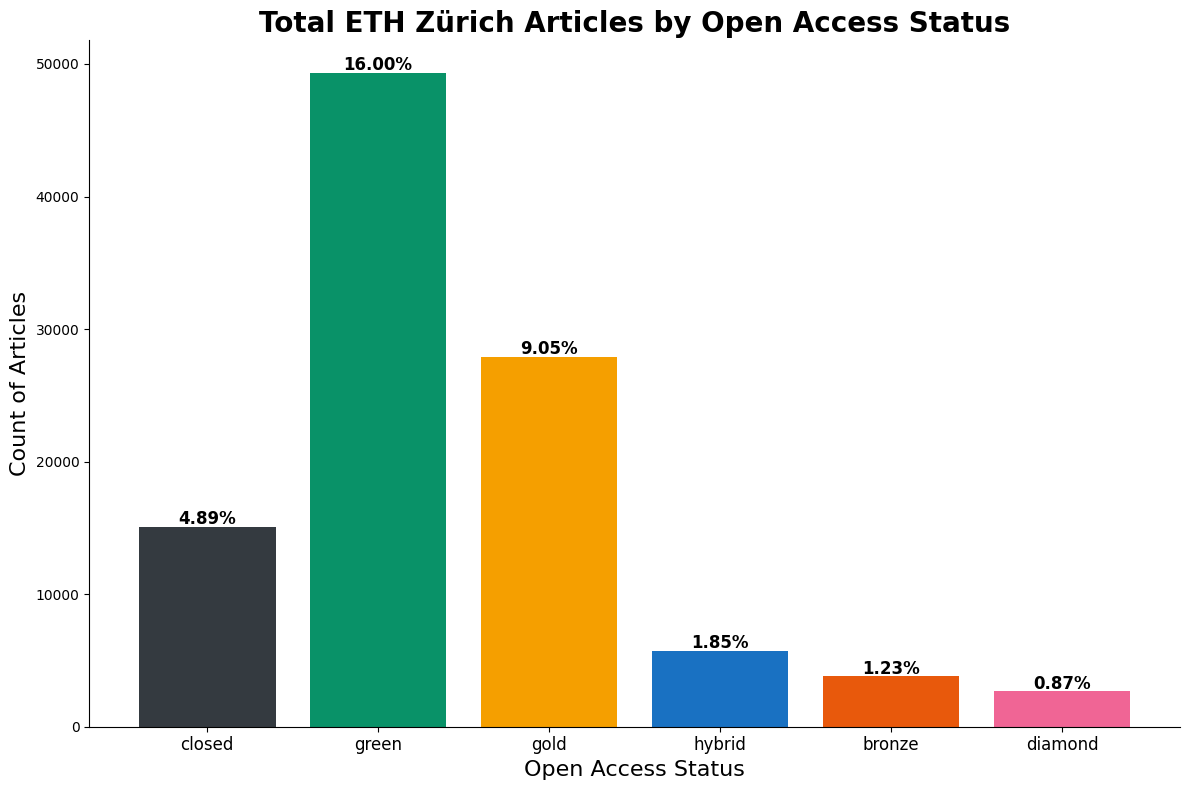

In [40]:
plot_total_oa_status(df_oa_status, "Total ETH Zürich Articles by Open Access Status")

#### (Alternative / Extension) Proportions of Articles by Open Access Status for each year.

##### Step 2.8: Fetch status data for each year

In [41]:
def fetch_oa_status_by_year(institution_id, start_year, end_year, base_url):
    oa_status_counts_by_year = {
        "Year": [],
        "green": [],
        "bronze": [],
        "gold": [],
        "hybrid": [],
        "closed": [],
        "diamond": []
    }

    for year in range(start_year, end_year + 1):
        green_total = build_green_total_url(institution_id, year, year, base_url)
        green_gold = build_green_gold_url(institution_id, year, year, base_url)
        bronze_url = build_bronze_url(institution_id, year, year, base_url)
        gold_url = build_gold_url(institution_id, year, year, base_url)
        hybrid_url = build_hybrid_url(institution_id, year, year, base_url)
        non_oa_url = build_non_oa_url(institution_id, year, year, base_url)  
        diamond_url = build_diamond_url(institution_id, year, year, base_url)

        green_total_count = process_data(fetch_data(green_total))
        green_gold_count = process_data(fetch_data(green_gold))
        green_count = green_total_count - green_gold_count
        bronze_count = process_data(fetch_data(bronze_url))
        gold_count = process_data(fetch_data(gold_url))
        hybrid_count = process_data(fetch_data(hybrid_url))
        non_oa_count = process_data(fetch_data(non_oa_url))
        diamond_count = process_data(fetch_data(diamond_url))

        # Append data for each year
        oa_status_counts_by_year["Year"].append(year)
        oa_status_counts_by_year["green"].append(green_count)
        oa_status_counts_by_year["bronze"].append(bronze_count)
        oa_status_counts_by_year["gold"].append(gold_count)
        oa_status_counts_by_year["hybrid"].append(hybrid_count)
        oa_status_counts_by_year["closed"].append(non_oa_count)
        oa_status_counts_by_year["diamond"].append(diamond_count)

    # Convert to DataFrame
    df_oa_by_year = pd.DataFrame(oa_status_counts_by_year)

    return df_oa_by_year


##### Step 2.9: Create Plot for Stacked Bar Chart

In [42]:
def plot_stacked_oa_status_by_year(df, title):
    categories = ["closed", "green", "gold", "hybrid", "bronze", "diamond"]
    plot_colors = [colors["gray"][8], colors["teal"][8], colors["yellow"][7], colors["blue"][8], colors["orange"][8], colors["pink"][5]]

    years = df["Year"]
    values = df[categories]

    fig, ax = plt.subplots(figsize=(14, 7))
    bottom = np.zeros(len(df))  # Initialize bottom of stack

    # Loop through categories and stack bars
    for i, category in enumerate(categories):
        ax.bar(
            years,
            values[category],
            label=category.capitalize(),
            color=plot_colors[i],
            bottom=bottom
        )
        bottom += values[category]

    # Formatting
    ax.set_title(title, fontsize=20, fontweight="bold")
    ax.set_xlabel("Year", fontsize=12)
    ax.set_ylabel("Number of Publications", fontsize=12)
    ax.set_xticks(years)
    ax.tick_params(axis='x')
    ax.legend(
        title="Open Access Status",
        loc="upper center",
        bbox_to_anchor=(0.5, -0.17),
        ncol=len(categories)
    )
    
    # Move legend below plot
    ax.spines[['top', 'right']].set_visible(False)
    plt.tight_layout()
    plt.show()

##### Step 2.10: Create DataFrame 

In [43]:
df_oa_by_year = fetch_oa_status_by_year(institution_id, start_year, end_year, base_url)

Request URL: https://api.openaire.eu/graph/v1/researchProducts?relOrganizationId=openorgs____%3A%3Afb1e14f93f04d43e1a10a9f17d12c669&type=publication&instanceType=Article&bestOpenAccessRightLabel=OPEN&isInDiamondJournal=False&isGreen=True&fromPublicationDate=2016&toPublicationDate=2016&pageSize=1
Request URL: https://api.openaire.eu/graph/v1/researchProducts?relOrganizationId=openorgs____%3A%3Afb1e14f93f04d43e1a10a9f17d12c669&type=publication&instanceType=Article&bestOpenAccessRightLabel=OPEN&isInDiamondJournal=False&isGreen=True&openAccessColor=gold&fromPublicationDate=2016&toPublicationDate=2016&pageSize=1
Request URL: https://api.openaire.eu/graph/v1/researchProducts?relOrganizationId=openorgs____%3A%3Afb1e14f93f04d43e1a10a9f17d12c669&type=publication&instanceType=Article&bestOpenAccessRightLabel=OPEN&isInDiamondJournal=False&isGreen=False&openAccessColor=bronze&fromPublicationDate=2016&toPublicationDate=2016&pageSize=1
Request URL: https://api.openaire.eu/graph/v1/researchProducts?r

In [44]:
df_oa_by_year

,Year,green,bronze,gold,hybrid,closed,diamond
0,2016,3190,579,2108,373,1714,214
1,2017,3657,610,2321,312,1573,234
2,2018,4226,664,2448,316,1664,293
3,2019,4634,661,2808,383,1831,290
4,2020,5379,649,3431,605,1718,289
5,2021,6014,541,3729,686,1463,297
6,2022,6145,80,3336,655,1466,315
7,2023,6571,6,3248,839,1503,287
8,2024,6204,5,2958,898,1334,315
9,2025,3298,0,1512,646,807,143


##### Step 2.11: Display Stacked Bar Chart

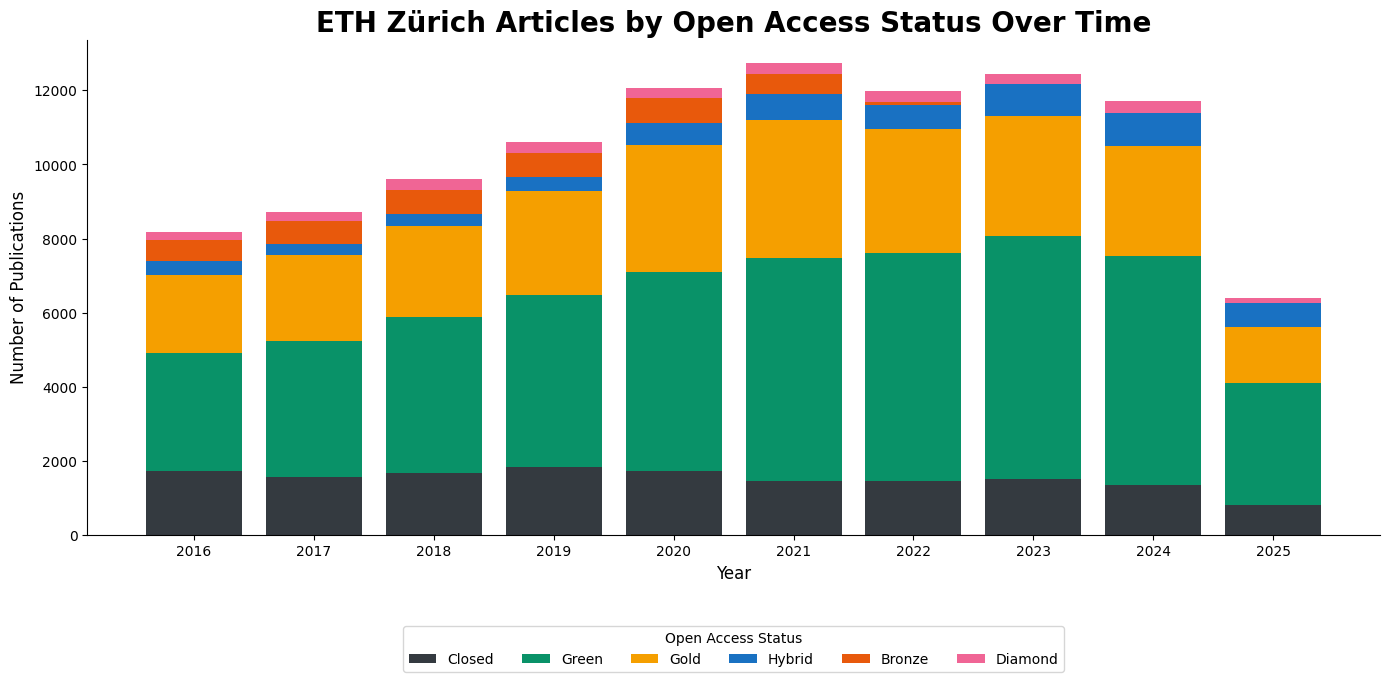

In [45]:
plot_stacked_oa_status_by_year(df_oa_by_year, "ETH Zürich Articles by Open Access Status Over Time")